In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.datasets.imagenet import ImageNet
from torchvision.transforms import ToTensor

In [3]:
print("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
!nvcc --version

cuda
2.1.1+cu121
12.1
8801
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


**학습 데이터에 가우시안 노이즈를 추가하는 함수**

In [4]:
def gaussian_noise(x,scale = 0.8):
    # 노이즈를 추가
    # 예시 표준편차는 0.8
    gaussian_x = x + np.random.normal(loc = 0,
                                      scale = scale,
                                      size = x.shape)
    # 이미지 픽셀값을 0과 1사이로 정규화
    gaussian_x = np.clip(gaussian_x,0,1)
    # torch tensor로 변환
    gaussian_x = torch.tensor(gaussian_x)
    gaussian_x = gaussian_x.type(torch.FloatTensor)
    return gaussian_x

**이미지 노이즈 비교**



C:\Users\user\AppData\Local\Temp\ipykernel_23720\304433251.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_x = torch.tensor(gaussian_x)


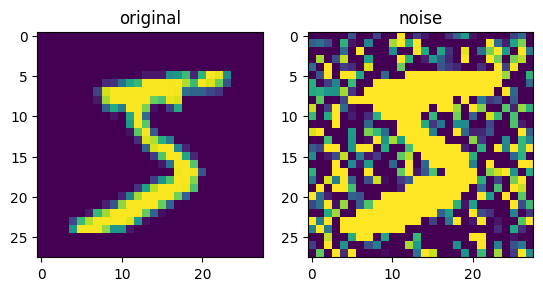

In [5]:
# 학습 데이터
training_data = MNIST(
    root='./',
    train = True,
    download = True,
    transform = ToTensor()
)
# 평가 데이터
test_data = MNIST(
    root = './',
    train = False,
    download = True,
    transform = ToTensor()
)

# sample
img = training_data.data[0]
gaussian_img = gaussian_noise(img)

plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("noise")
plt.imshow(gaussian_img)


**학습용 데이터 만들기**

In [6]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):
        # 원본 MNIST 데이터
        self.mnist = MNIST(
            root = './',
            train = True,
            download = True,
            transform = ToTensor()
        )
        self.data = [] # 노이즈 데이터 리스트
        # 노이즈 입히기
        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i])
            input_tensor = torch.tensor(noisy_input)
            self.data.append(torch.unsqueeze(input_tensor,dim = 0))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,i):
        data = self.data[i]

        # 원본 이미지도 0과 1사이로 값을 맞춰줌
        label = self.mnist.data[i]/255

        return data,label

**인코더 모델 정의**

In [7]:
import torch.nn as nn

class BasicBlock(nn.Module): #기본 블럭
    def __init__(self,in_channels, out_channels, hidden_dim):
        super(BasicBlock,self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            hidden_dim,
            kernel_size = 3,
            padding = 1
        )
        self.conv2 = nn.Conv2d(
            hidden_dim,
            out_channels,
            kernel_size = 3,
            padding = 1
        )
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [8]:
# prompt: BasicBlock 실행 후 maxpooling , BasicBlock, maxpooling 후 출력하는 Encoder를 만들어줘

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.block1 = BasicBlock(1,8,4)
        self.maxpool1 = nn.MaxPool2d(2)
        self.block2 = BasicBlock(8,8,4)
        self.maxpool2 = nn.MaxPool2d(2)
    def forward(self,x):
        x = self.block1(x)
        x = self.maxpool1(x)
        x = self.block2(x)
        x = self.maxpool2(x)
        return x


**디코더 모델 정의**

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = BasicBlock(in_channels=8, out_channels=8,hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16,hidden_dim=16)

        # 출력층으로 기본 블럭이 아닌 합성곱층
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 1,
                               kernel_size = 3, padding = 1)
        # upsampling layer
        self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size = 2, stride = 2)
        self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size = 2, stride = 2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)

        return x

**CAE 모델 정의**


In [10]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE,self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self,x):
        x = self.enc(x) # 인코더로 특징 추출
        x = self.dec(x) # 디코더로 이미지 복원
        x = torch.squeeze(x) # 채널 차원 삭제

        return x

**학습**

In [10]:
import tqdm
import time

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

trainset = Denoising()  # 학습 데이터셋
train_loader = DataLoader(trainset, batch_size = 32) # 한번에 32장씩

model = CAE().to(device) # 디노이징에 사용할 오토인코더 모델

lr = 0.001
optim = Adam(params = model.parameters(),lr = lr)
startTime = time.time()
for epoch in range(100):
    iterator = tqdm.tqdm(train_loader)

    for data,label in iterator:
        optim.zero_grad()
        pred = model(data.to(device))

        loss = nn.MSELoss()(torch.squeeze(pred),label.to(device)) # loss
        loss.backward()
        optim.step()
        iterator.set_description(f"epoch{epoch+1}, loss:{loss.item()}")

torch.save(model.state_dict(),"./CAE_100.pth") # 가중치 저장
endTime = time.time()
print(f"total training time:{startTime-endTime}")

# 모델 저장
torch.save(model.state_dict(), "testmodel.pth")
print(f"model saved, name: 'testmodel.pth'")

C:\Users\user\AppData\Local\Temp\ipykernel_30332\304433251.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_x = torch.tensor(gaussian_x)
C:\Users\user\AppData\Local\Temp\ipykernel_30332\3085228256.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch100, loss:0.008905266411602497: 100%|██████████| 1875/1875 [00:14<00:00, 125.87it/s] 


total training time:-1473.564549446106
model saved, name: 'testmodel.pth'


**모델 성능 평가**

cuda
cuda


C:\Users\user\AppData\Local\Temp\ipykernel_30332\304433251.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_x = torch.tensor(gaussian_x)


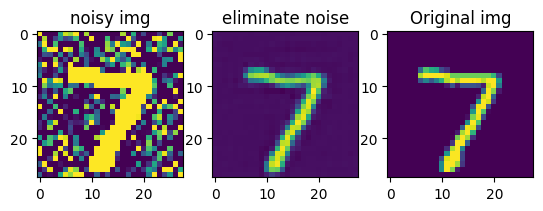

In [13]:
print("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.cpu()

with torch.no_grad():
    # 가중치 load
    model.load_state_dict(torch.load("./CAE_100.pth",map_location=device))

    img = test_data.data[0] # test original
    gaussian = gaussian_noise(img)  # test noise

    # 모델 입력 차원에 맞춰 채널 차원 추가
    input = torch.unsqueeze(gaussian, dim = 0)
    input.type(torch.FloatTensor) # 가중치와 입력의 데이터 타입을 맞춤
    input.to(device)
    input = torch.unsqueeze(input, dim = 0) # batch size 1을 위한 배치 차원 추가

    plt.subplot(1,3,1)
    plt.title("noisy img")
    plt.imshow(torch.squeeze(gaussian))
    plt.subplot(1,3,2)
    plt.title("eliminate noise")
    plt.imshow(torch.squeeze(model(input)))
    plt.subplot(1,3,3)
    plt.title("Original img")
    plt.imshow(torch.squeeze(img))
    plt.show()

**실제 사진으로 노이즈제거**

RuntimeError: Given groups=1, weight of size [4, 1, 3, 3], expected input[1, 3, 16, 16] to have 1 channels, but got 3 channels instead

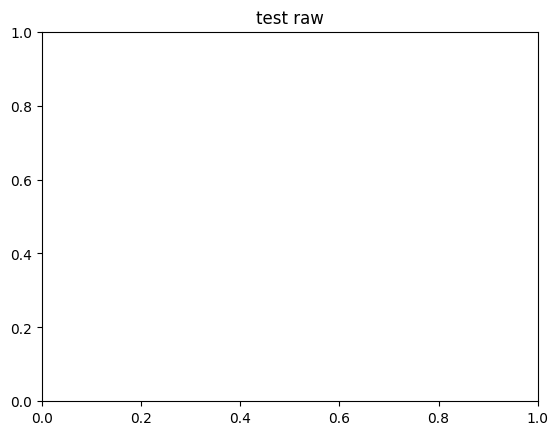

In [12]:
import torch
from PIL import Image
import torchvision.transforms as transforms



# model load
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CAE().to(device)
model.load_state_dict(torch.load("testmodel.pth"))


# Example usage:
input_path = "testCAE_image.JPG"
size = (16, 16)  
transform = transforms.Compose([
    transforms.Resize(size),  
    transforms.ToTensor(), 
])


image = Image.open(input_path)
input = transform(image).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    # 가중치 load
    model.load_state_dict(torch.load("./CAE_100.pth",map_location=device))

    
    input.type(torch.FloatTensor) # 가중치와 입력의 데이터 타입을 맞춤
    input.to(device)
    
    plt.title("test raw")
    plt.imshow(torch.squeeze(model(input)))
    plt.show()
